# NYCU Machine Learning 2024 : HW4 SVM

In [1]:

import numpy as np
import cvxpy as cp
import pandas as pd

from pathlib import Path
from rich import print
from dataclasses import dataclass, field
from typing import Callable
import matplotlib.pyplot as plt
import json

In [36]:
np.set_printoptions(precision=4)

In [37]:
LABEL = ["Setosa" , "Versicolor" , "Virginica" ]

COLOR_1 = dict(zip(LABEL, ["red" , "green" , "blue"]))
COLOR_2 = dict(zip(LABEL, ["pink" , "yellow" , "orange"]))
COLOR_3 = dict(zip(LABEL, ["brown", "lightgreen", "navy", "magenta"]))
COLOR_4 = dict(zip(LABEL, ["teal", "gold", "violet", "coral"]))

COLOR_SELECT = {
    "before": {
        "train":COLOR_1,
        "test":COLOR_2,
    },
    "after": {
        "train":COLOR_3,
        "test":COLOR_4,
    }
}

COLUMN_NAME = ["Sepal length", "Sepal width" , "Petal length" , "Petal width" , "Label"]
TRAIN_DATA_SIZE = 25
ASSETS = "./assets"

In [38]:
assets_folder = Path(ASSETS)
assets_folder.mkdir(parents=True, exist_ok=True) 

In [39]:
def load_iris_file(with_name:bool=False)->pd.DataFrame:
    df = pd.read_fwf("./iris.txt")
    
    df_new = pd.DataFrame({k:[v] for k ,v in zip(COLUMN_NAME , df.columns)},dtype=float)
    df.columns = COLUMN_NAME
    df_new = pd.concat([df_new, df], axis=0).reset_index().drop(columns=["index"])
    
    if not with_name:
        return df_new
    
    df_with_name = df_new.copy()
    
    df_with_name["Label"] = df_with_name["Label"].apply(lambda x : LABEL[int(x)-1])
    
    return df_with_name

In [40]:
df = load_iris_file(with_name=True)
df

,Sepal length,Sepal width,Petal length,Petal width,Label
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [41]:
POSITIVE_CLASS ,NEGATIVE_CLASS= "Versicolor" , "Virginica"

In [42]:
df_need = df[["Petal length","Petal width", "Label"]]
df_need

,Petal length,Petal width,Label
0,1.4,0.2,Setosa
1,1.4,0.2,Setosa
2,1.3,0.2,Setosa
3,1.5,0.2,Setosa
4,1.4,0.2,Setosa
...,...,...,...
145,5.2,2.3,Virginica
146,5.0,1.9,Virginica
147,5.2,2.0,Virginica
148,5.4,2.3,Virginica


In [43]:
df_need_pos = df_need[df_need["Label"] == POSITIVE_CLASS]
df_need_pos_train , df_need_pos_test = df_need_pos[:TRAIN_DATA_SIZE], df_need_pos[TRAIN_DATA_SIZE:]

In [44]:
df_need_neg = df_need[df_need["Label"] == NEGATIVE_CLASS]
df_need_neg_train , df_need_neg_test = df_need_neg[:TRAIN_DATA_SIZE], df_need_neg[TRAIN_DATA_SIZE:]

In [45]:
df_need_train = pd.concat([df_need_pos_train, df_need_neg_train]).reset_index().drop(columns=["index"])
df_need_test  = pd.concat([df_need_pos_test, df_need_neg_test]).reset_index().drop(columns=["index"])

In [46]:
label_to_index = {POSITIVE_CLASS : 1 , NEGATIVE_CLASS : -1}
index_to_label = {1 : POSITIVE_CLASS , -1 : NEGATIVE_CLASS}


label_to_index_np = np.vectorize(label_to_index.get)
index_to_label_np = np.vectorize(index_to_label.get)

## Model

In [66]:

def rbf(sigma: float) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    def run(x_1: np.ndarray, x_2: np.ndarray) -> np.ndarray:
        # 检查维度是否匹配
        assert x_1.shape[0] == x_2.shape[0], "输入的两个向量必须有相同的特征数"

        # upper = np.square(np.linalg.norm(x_1-x_2 , axis=0))
        
        # return np.exp(-upper / (2 * sigma ** 2))
        
        # 计算欧氏距离的平方
        distance_squared = np.sum((x_1 - x_2) ** 2, axis=0)
        
        # 计算 RBF 核函数值
        kernel_value = np.exp(-distance_squared / (2 * sigma ** 2))
        
        if x_2.ndim != 1 and x_2.shape[1] == 1:
            kernel_value = kernel_value.reshape(-1,1)
            
        
        return kernel_value

    return run

def poly(p:int)-> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    def run(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
        assert x_1.shape[0] == x_2.shape[0], "输入的两个向量必须有相同的特征数"
        
        return (x_1.T @ x_2)**p
    
    return run

def linear() -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    
    def run(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
        assert x_1.shape[0] == x_2.shape[0], "输入的两个向量必须有相同的特征数"
        
        return x_1.T @ x_2
    
    return run

class Kernel:
    kernel_dict = {
        "linear":linear,
        "rbf": rbf,
        "poly": poly,
    }
        
    @staticmethod
    def get_kernel(name:str, config:dict) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
        if name not in Kernel.kernel_dict:
            raise NotImplementedError(f"{name} kernel not implemented. Available kernels: {list(Kernel.kernel_dict.keys())}")
        
        func = Kernel.kernel_dict[name]
        
        return func(**config) 

In [67]:
class SupportVectorMachine:
    def __init__(self, C:int, kernel_name:str="linear", kernel_arg:dict=dict(),threshold:float=1e-20):
        self._c = C
        self._threshold = threshold
        # like ("ay": ... , "x": ...,)
        self._a_y_x :np.ndarray = None
        self._b :float = None
        self._kernel  = Kernel.get_kernel(kernel_name, kernel_arg)
        self._kernel_info = {"name":kernel_name, "arg": kernel_arg}
        return
    
    @property
    def alpha(self)->np.ndarray:
        return self._a_y_x[:, 0].reshape(-1,1)
    
    @property
    def bias(self)->np.ndarray:
        return self._b
    
    def _build_k_matrix(self, x:np.ndarray)->np.ndarray:
        size = x.shape[0]
        return np.array([[self._kernel(x[i], x[j]) for j in range(size)] for i in range(size)])
    
    def _find_alpha(self, K:np.ndarray, x:np.ndarray , y:np.ndarray)-> tuple[np.ndarray,np.ndarray]:
        size = x.shape[0] 
        alpha = cp.Variable(size)
        
        big_k = np.outer(y,y) * K  
        big_k = cp.psd_wrap(big_k)
        
        objective = cp.Minimize((1/2) * cp.quad_form(alpha, big_k) -cp.sum(alpha))
        constraints = [
            cp.sum(cp.multiply(alpha, y)) == 0,  
            alpha >= 0, 
            alpha <= self._c
        ]
        problem = cp.Problem(objective, constraints) 
        problem.solve(solver=cp.CLARABEL) # verbose=True
        alpha = alpha.value
        
        # filter the important one 
        support_vectors = np.where((self._c >= alpha)& (alpha > self._threshold) )[0]
        return alpha , support_vectors
    
    def _find_bias(self,alpha:np.ndarray,support_vectors:np.ndarray, y: np.ndarray, K: np.ndarray):
        K_hat = K[support_vectors][:, support_vectors]
        alpha_hat = alpha[support_vectors]
        y_hat = y[support_vectors]
        
        res = y_hat - K_hat @ (alpha_hat * y_hat)
        
        return np.mean(res)
    
    def train(self, x:np.ndarray, y:np.ndarray): # [batch, feature]   [batch, 1]
        # get the a
        K = self._build_k_matrix(x) 
        # print(K)
        alpha , support_vector = self._find_alpha(K,x,y)
        # find the best b
        self._b = self._find_bias(alpha,support_vector,y,K)
        
        alpha , y = alpha.reshape(-1,1), y.reshape(-1,1)
        
        table = np.hstack((alpha , y, x))
        
        self._a_y_x = table[support_vector]
        
        return 
    
    def cal_one_item(self, ay:np.ndarray, x_kernel:np.ndarray, x_item: np.ndarray)->np.ndarray:
        # x [1, feature]
        # x_kernel [a, feature]
        
        res = np.sum(ay * self._kernel(x_kernel.T, x_item.reshape(-1,1))) + self._b
        
        return res
    
    def __call__(self, x : np.ndarray, with_sign:bool=False)->np.ndarray:
        # x [batch, feature]
        a, y, x_kernel = self._a_y_x[:, 0].reshape(-1,1) , self._a_y_x[:, 1].reshape(-1,1),  self._a_y_x[:, 2:]
        
        result = [self.cal_one_item(a*y, x_kernel=x_kernel, x_item=x_item) for x_item in x]
        res = np.hstack(result) 
        
        if with_sign:
            res = np.sign(res)
        
        return res
    
    def acc(self, x: np.ndarray,y: np.ndarray)->tuple[float, np.ndarray]:
        
        y_hat = self.__call__(x, True)
        
        return np.mean(y_hat == y) , y_hat
    
    @property
    def info(self):
        return {"kernel": self._kernel_info, "support vector num":self._a_y_x.shape[0] , "C" : self._c, "b":f"{self._b:.4f}"}
    @property
    def short_name(self):
        kernel_name = self._kernel_info['name']
        
        if len(self._kernel_info["arg"]) > 0:
            kernel_arg_name, kernel_arg = next(iter(self._kernel_info["arg"].items()))
            
        else :
            kernel_arg_name, kernel_arg = "", ""
        return f"{kernel_name}_{kernel_arg_name}_{kernel_arg}_C_{self._c}"
    
    def __str__(self):
        return str(self.info)
    
    def __repr__(self):
        return self.__str__()
    

In [68]:
model = SupportVectorMachine(C =10 , kernel_name="rbf", kernel_arg={"sigma":2} ) # , kernel_name="rbf",kernel_arg={"sigma" : 2}

In [69]:

@dataclass
class TestResult:
    model:SupportVectorMachine
    acc : float
    bias_ : str
    alpha : np.ndarray
    
    bias : float = field(repr=False)
    x_test : np.ndarray = field(repr=False)
    y_test : np.ndarray = field(repr=False)
    y_hat : np.ndarray = field(repr=False)
    
    @classmethod
    def build(cls, model:SupportVectorMachine, x:np.ndarray, y:np.ndarray):
        model = model
        acc, y_hat = model.acc(x=x,y=y)
        alpha = model.alpha.reshape(-1)
        bias = model.bias
        bias_ = f"{model.bias:.4f}"
        
        return cls(model, acc,bias_,alpha,bias, x,y,y_hat)
    
    def to_data_dict(self,image_save_folder:Path=None) -> dict:
        data = {
            "model_name":str(self.model.short_name),
            "acc" : f'{self.acc:.2f}',
            "alpha" : str([f"{item:.4f}" for item in self.alpha.tolist()]),
            "bias" : self.bias_,
        }
        
        if image_save_folder is not None:
            filename = image_save_folder.joinpath(f"{self.model.short_name}.png")
            data |= {"image" : f"![alt]({filename})"}
        
        return data  
    
    def plot_decision_boundary(self,save_folder:Path=None, resolution=100, padding=1.0, with_contours=True):
        """
        绘制任何二维模型的决策边界。

        Parameters:
        - model: 训练好的模型，必须支持 `predict` 或类似接口 (可以传入自定义SVM模型)。
        - x: 训练数据，形状为 [num_samples, 2]。
        - y: 训练标签，形状为 [num_samples] 或 [num_samples, 1]。
        - resolution: 网格的分辨率，默认为 100。
        - padding: 数据边界填充距离，以保证决策边界的完整显示。
        - with_contours: 是否显示轮廓线，默认为 True。
        """
        # 设定网格范围
        x,y  = self.x_test, self.y_test
        x_min, x_max = x[:, 0].min() - padding, x[:, 0].max() + padding
        y_min, y_max = x[:, 1].min() - padding, x[:, 1].max() + padding
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        # 在网格点上获取模型的预测值
        Z = self.model(grid_points, with_sign=True)
            
        Z = Z.reshape(xx.shape)

        # 绘制训练数据点和决策边界
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', s=50, edgecolors='k')
        plt.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")
        
        if with_contours:
            plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=["--", "-", "--"], colors="k")
            
        # 添加图例和标签
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.title(f"Model decision boundary\nModel:{self.model}\nAcc:{self.acc*100:.2f}%")
        
        if save_folder is not None:
            filename = save_folder.joinpath(f"{self.model.short_name}.png")
            plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  

        plt.show()

In [70]:
def test_run(df_train:pd.DataFrame, df_test:pd.DataFrame, kernel_name:str , kernel_arg:dict=dict(), C_list:list[int] = [1,10,100]):
    
    if len(kernel_arg) != 0:
        kernel_item = next(iter(kernel_arg.items()))
        kernel_arg_name ,kernel_arg_value_list = kernel_item
        kernel_arg_list = [{kernel_arg_name: item} for item in kernel_arg_value_list]
    else:
        kernel_arg_list = [dict()]
    # return 
    train_x , train_y = df_train.drop(columns=["Label"]).to_numpy() , df_train["Label"].to_numpy() 
    test_x , test_y = df_test.drop(columns=["Label"]).to_numpy() , df_test["Label"].to_numpy() 
    
    train_y, test_y = label_to_index_np(train_y), label_to_index_np(test_y)
    
    model_list = []
    
    for kernel_arg_item in kernel_arg_list:
        for c in C_list:
            model = SupportVectorMachine(
                C=c,
                kernel_name=kernel_name,
                kernel_arg=kernel_arg_item
            )
            model.train(x=train_x, y=train_y)
            
            result = TestResult.build(model, x=test_x, y=test_y)
            
            model_list.append(result)
    
    
    return model_list

## Test Linear

In [71]:
model_linear = test_run(
    df_train=df_need_train,
    df_test=df_need_test,
    kernel_name="linear",
)

In [72]:
print(model_linear)

[
    TestResult(
        model={'kernel': {'name': 'linear', 'arg': {}}, 'support vector num': 50, 'C': 1, 'b': '10.6297'},
        acc=np.float64(0.96),
        bias_='10.6297',
        alpha=array([1.0000e+00, 6.6667e-02, 1.0000e+00, 4.8799e-11, 1.0000e+00,
       1.2896e-10, 1.0000e+00, 1.5628e-11, 1.8811e-10, 5.4316e-11,
       1.8377e-11, 1.6861e-10, 2.8067e-11, 1.0000e+00, 3.0077e-11,
       1.7918e-10, 6.6667e-02, 3.0760e-11, 6.6667e-02, 2.9700e-11,
       1.0000e+00, 4.8799e-11, 1.0000e+00, 1.3244e-10, 7.9069e-11,
       2.0787e-11, 1.0000e+00, 3.8922e-11, 3.6439e-10, 3.5208e-11,
       2.2945e-11, 1.0000e+00, 4.8671e-11, 1.2641e-10, 1.9752e-11,
       1.0000e+00, 2.0000e-01, 6.1862e-11, 1.0000e+00, 4.1763e-11,
       4.4378e-11, 1.8952e-09, 1.9391e-11, 1.5977e-11, 1.0000e+00,
       3.2088e-11, 1.0000e+00, 2.4262e-11, 1.0000e+00, 4.7702e-11])
    ),
    TestResult(
        model={'kernel': {'name': 'linear', 'arg': {}}, 'support vector num': 50, 'C': 10, 'b': '15.0764'},
        acc=np.float64(0.94),
        bias_='15.0764',
        alpha=array([3.0420e-10, 4.0754e-10, 9.0000e+00, 1.0620e-10, 5.3331e-10,
       1.5736e-10, 1.0000e+01, 4.5154e-11, 1.7293e-10, 1.2399e-10,
       5.0345e-11, 2.3911e-10, 6.4699e-11, 3.0420e-10, 8.0863e-11,
       1.9999e-10, 4.0754e-10, 6.8054e-11, 4.0754e-10, 7.0448e-11,
       1.0000e+01, 1.0620e-10, 9.0000e+00, 1.4142e-10, 1.3302e-10,
       5.6960e-11, 8.0000e+00, 1.0904e-10, 8.6025e-10, 9.4465e-11,
       7.5255e-11, 1.0000e+01, 1.8757e-10, 4.2013e-10, 5.5020e-11,
       3.2493e-10, 6.1979e-10, 1.4250e-10, 3.3266e-10, 9.4982e-11,
       1.0214e-10, 1.8259e-09, 6.2808e-11, 5.2305e-11, 1.0000e+01,
       8.3617e-11, 1.8418e-10, 8.4354e-11, 1.0000e+01, 1.2384e-10])
    ),
    TestResult(
        model={'kernel': {'name': 'linear', 'arg': {}}, 'support vector num': 50, 'C': 100, 'b': '11.2977'},
        acc=np.float64(0.92),
        bias_='11.2977',
        alpha=array([7.4693e-09, 2.5846e-04, 4.4444e+01, 5.2582e-09, 3.5908e-04,
       3.7132e-09, 1.0000e+02, 1.9094e-09, 3.4000e-09, 1.6088e-08,
       1.7549e-09, 1.3843e-04, 1.4438e-09, 7.4693e-09, 6.6283e-09,
       1.1058e-08, 2.5846e-04, 1.3895e-09, 2.5846e-04, 2.0356e-09,
       1.0000e+02, 5.2582e-09, 4.4444e+01, 1.9418e-09, 4.3305e-09,
       9.6661e-10, 7.1595e-09, 2.9218e-09, 1.3464e-04, 1.8799e-09,
       3.7969e-09, 1.0000e+02, 6.2639e-05, 1.0010e-04, 9.9210e-10,
       2.9510e-09, 9.6917e-09, 2.3996e-09, 2.6503e-09, 8.9698e-10,
       1.1639e-09, 1.6231e-04, 2.5546e-09, 1.9380e-09, 1.0000e+02,
       1.3512e-09, 2.4097e-09, 7.2161e-09, 8.8888e+01, 2.6646e-09])
    )
]

## Test RBF

In [73]:
model_rbf = test_run(
    df_train=df_need_train,
    df_test=df_need_test,
    kernel_name="rbf",
    kernel_arg={"sigma": [5, 1,0.5,0.1, 0.05]},
    C_list=[10],
)

In [74]:
print(model_rbf)

[
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 5}}, 'support vector num': 50, 'C': 10, 'b': '0.0049'},
        acc=np.float64(0.9),
        bias_='0.0049',
        alpha=array([1.0000e+01, 8.9618e+00, 1.0000e+01, 1.7389e-09, 1.0000e+01,
       5.8482e-09, 1.0000e+01, 7.9645e-10, 1.3224e-08, 1.6625e-09,
       9.0078e-10, 3.1312e-09, 1.3712e-09, 1.0000e+01, 1.1369e-09,
       4.8521e-09, 8.9618e+00, 1.5363e-09, 8.9618e+00, 1.3239e-09,
       1.0000e+01, 1.7389e-09, 1.0000e+01, 2.6972e-08, 2.9620e-09,
       1.3652e-09, 1.0000e+01, 2.2120e-09, 6.5950e+00, 2.3655e-09,
       1.0185e-09, 1.0000e+01, 1.6354e-09, 3.9577e-09, 1.2340e-09,
       1.0000e+01, 1.0000e+01, 7.9271e-09, 1.0000e+01, 2.9050e-01,
       1.5892e-08, 1.0000e+01, 9.0498e-10, 7.7160e-10, 1.0000e+01,
       2.5423e-09, 1.0000e+01, 9.9786e-10, 1.0000e+01, 3.4109e-09])
    ),
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 1}}, 'support vector num': 50, 'C': 10, 'b': '-0.2601'},
        acc=np.float64(0.96),
        bias_='-0.2601',
        alpha=array([1.5639e-09, 1.0971e-09, 8.8908e+00, 1.0012e-09, 1.3275e-09,
       9.4984e-10, 1.0000e+01, 3.4598e-01, 1.0672e-09, 1.1960e-09,
       4.1520e-09, 8.6162e-10, 8.8174e-10, 1.5639e-09, 3.6895e-09,
       9.6721e-10, 1.0971e-09, 8.0344e-10, 1.0971e-09, 1.0321e-09,
       1.0000e+01, 1.0012e-09, 8.8908e+00, 1.0843e-09, 8.6266e-10,
       9.4682e-10, 8.1275e+00, 8.6788e-10, 1.3409e-09, 7.6468e-10,
       6.3880e-09, 1.0000e+01, 3.4365e-09, 1.3644e-09, 1.1102e-09,
       1.9551e-09, 1.1045e-09, 7.7834e-10, 5.4070e-09, 1.1579e-09,
       8.6583e-10, 1.6182e-09, 1.1140e-08, 8.8532e-08, 1.0000e+01,
       7.2005e-10, 8.3832e-05, 1.4382e-08, 1.0000e+01, 7.6460e-10])
    ),
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 0.5}}, 'support vector num': 50, 'C': 10, 'b': 
'-0.3942'},
        acc=np.float64(0.96),
        bias_='-0.3942',
        alpha=array([6.4813e-10, 1.0597e-09, 5.9852e+00, 1.5268e-09, 1.0189e-09,
       4.3803e-10, 5.3969e+00, 1.0033e+00, 4.4533e-10, 2.5511e-08,
       6.9096e-09, 3.0060e+00, 1.6271e-09, 6.4813e-10, 1.1727e-08,
       6.4029e-10, 1.0597e-09, 1.1568e-09, 1.0597e-09, 1.6093e-09,
       1.0000e+01, 1.5268e-09, 5.9852e+00, 4.7262e-10, 5.5390e-10,
       2.5484e-01, 5.9051e-09, 1.6594e-09, 8.5214e-10, 1.6605e-09,
       1.6258e-08, 1.0000e+01, 2.9365e-01, 1.1272e-09, 1.4339e-01,
       2.0661e-09, 1.1170e-09, 8.4705e-10, 4.8718e-09, 3.8505e-09,
       1.5484e-09, 8.7752e-10, 1.3130e-08, 5.8350e-01, 1.0000e+01,
       2.0380e-09, 1.0121e-01, 3.2457e-06, 1.0000e+01, 1.0591e-09])
    ),
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 0.1}}, 'support vector num': 50, 'C': 10, 'b': 
'-0.1574'},
        acc=np.float64(0.88),
        bias_='-0.1574',
        alpha=array([2.8015e-01, 3.2924e-01, 1.2411e+00, 3.6312e-01, 7.0394e-02,
       7.0300e-01, 7.0711e-01, 1.0221e+00, 3.9401e-02, 8.6695e-01,
       1.0131e+00, 1.0463e+00, 2.5171e-01, 2.8015e-01, 1.1450e+00,
       1.0557e-01, 3.2924e-01, 9.2491e-01, 3.2924e-01, 9.1964e-01,
       2.5408e+00, 3.6312e-01, 1.2411e+00, 1.0054e+00, 9.1090e-01,
       5.2112e-01, 1.9371e-01, 7.0478e-01, 4.1016e-01, 1.3776e-01,
       4.1504e-01, 1.0583e+00, 8.4054e-01, 7.7116e-01, 5.2447e-01,
       5.3702e-01, 7.1105e-01, 7.2422e-01, 1.3637e-08, 7.7784e-01,
       7.6220e-01, 5.1606e-01, 5.3965e-01, 7.9478e-01, 2.3432e+00,
       6.9591e-01, 6.5022e-01, 6.1367e-01, 2.2924e+00, 4.9357e-01])
    ),
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 0.05}}, 'support vector num': 50, 'C': 10, 'b': 
'-0.1106'},
        acc=np.float64(0.82),
        bias_='-0.1106',
        alpha=array([0.5377, 0.3213, 0.6269, 0.5453, 0.9401, 0.9632, 1.0929, 1.1103,
       0.9401, 1.0907, 1.1103, 1.1105, 0.9579, 0.5377, 1.1106, 1.0552,
       0.3213, 0.9809, 0.3213, 1.093 , 1.2539, 0.5453, 0.6269, 1.093 ,
       1.0909, 0.7834, 0.783 , 0.8737, 0.7831, 0.8414, 0.8574, 0.8

## Test poly

In [75]:
model_poly = test_run(
    df_train=df_need_train,
    df_test=df_need_test,
    kernel_name="poly",
    kernel_arg={"p":[1,2,3,4,5]},
    C_list=[10],
)

In [76]:
print(model_poly)

[
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 1}}, 'support vector num': 50, 'C': 10, 'b': '15.0764'},
        acc=np.float64(0.94),
        bias_='15.0764',
        alpha=array([3.0420e-10, 4.0754e-10, 9.0000e+00, 1.0620e-10, 5.3331e-10,
       1.5736e-10, 1.0000e+01, 4.5154e-11, 1.7293e-10, 1.2399e-10,
       5.0345e-11, 2.3911e-10, 6.4699e-11, 3.0420e-10, 8.0863e-11,
       1.9999e-10, 4.0754e-10, 6.8054e-11, 4.0754e-10, 7.0448e-11,
       1.0000e+01, 1.0620e-10, 9.0000e+00, 1.4142e-10, 1.3302e-10,
       5.6960e-11, 8.0000e+00, 1.0904e-10, 8.6025e-10, 9.4465e-11,
       7.5255e-11, 1.0000e+01, 1.8757e-10, 4.2013e-10, 5.5020e-11,
       3.2493e-10, 6.1979e-10, 1.4250e-10, 3.3266e-10, 9.4982e-11,
       1.0214e-10, 1.8259e-09, 6.2808e-11, 5.2305e-11, 1.0000e+01,
       8.3617e-11, 1.8418e-10, 8.4354e-11, 1.0000e+01, 1.2384e-10])
    ),
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 2}}, 'support vector num': 50, 'C': 10, 'b': '14.7951'},
        acc=np.float64(0.9),
        bias_='14.7951',
        alpha=array([5.0887e-11, 2.3206e-11, 3.8295e+00, 1.6847e-11, 3.9587e-11,
       2.3075e-11, 9.4708e+00, 8.1377e-12, 3.0120e-11, 1.8613e-11,
       9.5377e-12, 1.5659e-11, 1.4113e-11, 5.0887e-11, 1.4755e-11,
       1.6997e-11, 2.3206e-11, 1.4416e-11, 2.3206e-11, 1.4798e-11,
       1.0000e+01, 1.6847e-11, 3.8295e+00, 3.2367e-11, 1.6802e-11,
       6.5652e-12, 3.4470e-11, 6.3598e-12, 3.7805e-12, 7.6320e-12,
       6.0229e-12, 1.0000e+01, 4.4466e-12, 2.0550e-12, 6.2729e-12,
       3.1446e-11, 1.6314e-11, 1.1263e-11, 4.2021e-11, 1.4882e-11,
       1.3887e-11, 6.2121e-12, 5.7703e-12, 4.6037e-12, 1.0000e+01,
       8.5786e-12, 5.4575e-11, 6.1906e-12, 7.1297e+00, 7.9782e-12])
    ),
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 3}}, 'support vector num': 50, 'C': 10, 'b': '8.2678'},
        acc=np.float64(0.88),
        bias_='8.2678',
        alpha=array([7.8159e-10, 5.8306e-10, 3.8735e+00, 2.2643e-10, 7.1916e-10,
       4.2124e-10, 8.5547e+00, 1.3044e-10, 5.8785e-10, 2.7372e-10,
       1.4952e-10, 4.4529e-10, 2.6582e-10, 7.8159e-10, 2.0359e-10,
       3.6045e-10, 5.8306e-10, 3.2811e-10, 5.8306e-10, 2.0267e-10,
       1.0000e+01, 2.2643e-10, 3.8735e+00, 2.3245e-01, 2.8816e-10,
       3.8192e-11, 3.6082e-10, 1.1120e-10, 4.6729e-10, 8.1159e-11,
       8.3087e-11, 1.0000e+01, 1.1093e-10, 2.7536e-10, 3.9091e-11,
       1.6739e-10, 3.5519e-10, 1.1242e-10, 1.5968e-10, 3.9682e-11,
       5.3987e-11, 6.4455e-10, 7.0882e-11, 5.6793e-11, 1.0000e+01,
       5.9082e-11, 1.5205e-10, 8.0244e-11, 6.5342e+00, 1.1350e-10])
    ),
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 4}}, 'support vector num': 50, 'C': 10, 'b': '7.0988'},
        acc=np.float64(0.86),
        bias_='7.0988',
        alpha=array([1.6805e-09, 5.6648e-10, 3.2052e+00, 3.3044e-10, 7.7865e-10,
       7.9040e-10, 6.1110e+00, 2.4953e-10, 1.2575e-09, 3.1911e-10,
       2.5543e-10, 2.8161e-10, 4.2975e-10, 1.6805e-09, 2.6987e-10,
       5.4270e-10, 5.6648e-10, 5.5450e-10, 5.6648e-10, 3.1439e-10,
       1.0000e+01, 3.3044e-10, 3.2052e+00, 2.0531e+00, 4.8109e-10,
       4.0540e-11, 6.1983e-10, 1.5345e-10, 1.0387e-10, 1.0648e-10,
       8.5483e-11, 1.0000e+01, 7.1192e-11, 8.5519e-11, 4.1633e-11,
       2.3597e-10, 5.7514e-10, 1.5333e-10, 2.1833e-10, 3.9244e-11,
       5.9368e-11, 1.5160e-10, 7.6242e-11, 6.2738e-11, 1.0000e+01,
       7.0483e-11, 1.9860e-10, 6.9973e-11, 4.5745e+00, 1.5862e-10])
    ),
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 5}}, 'support vector num': 50, 'C': 10, 'b': '6.6671'},
        acc=np.float64(0.78),
        bias_='6.6671',
        alpha=array([7.5496e-07, 9.2190e-07, 6.7458e+00, 3.3137e-07, 1.0504e-06,
       5.5075e-07, 3.1805e-05, 2.3693e-07, 6.7108e-07, 4.4872e-07,
       2.4426e-07, 9.0419e-07, 3.7645e-07, 7.5496e-07, 3.1883e-07,
       5.1053e-07, 9.2190e-07, 4.5922e-07, 9.2190e-07, 2.9181e-07,
       1.0000e+01, 3.3137e-07, 6.7458e+0

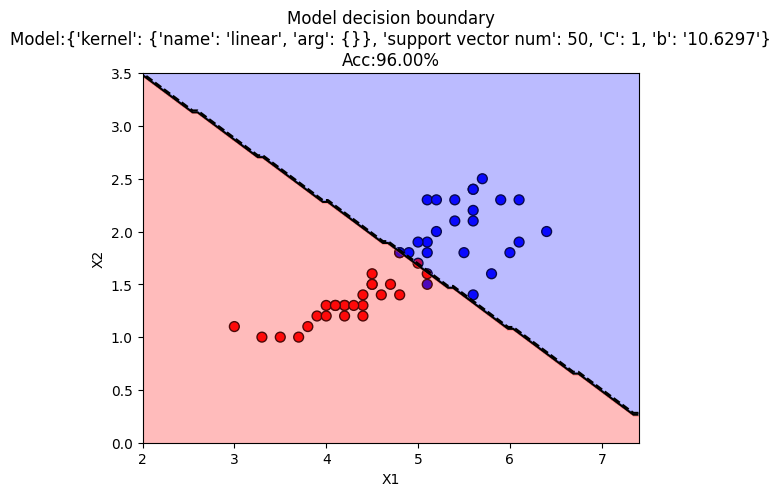

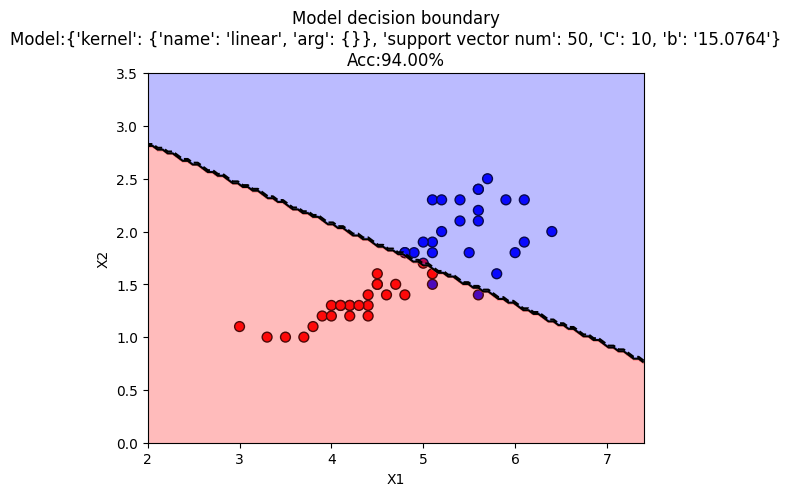

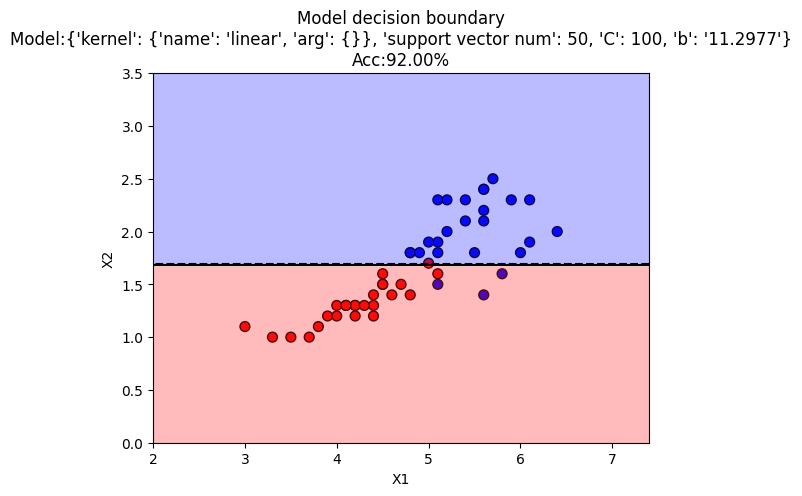

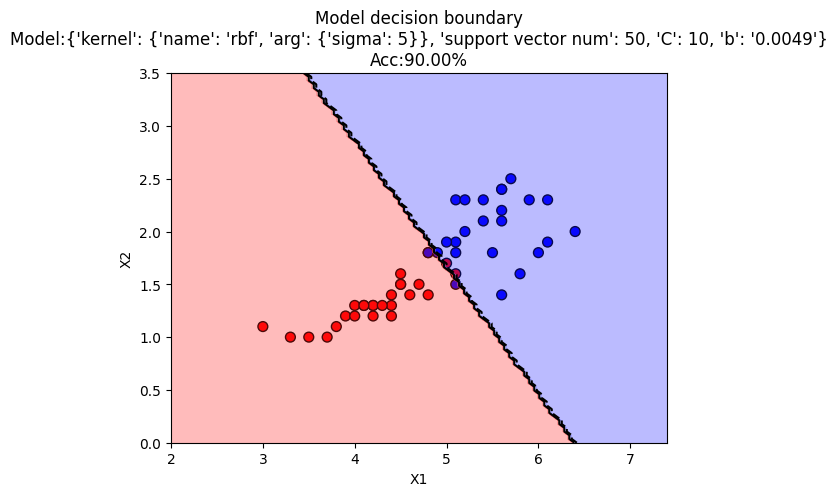

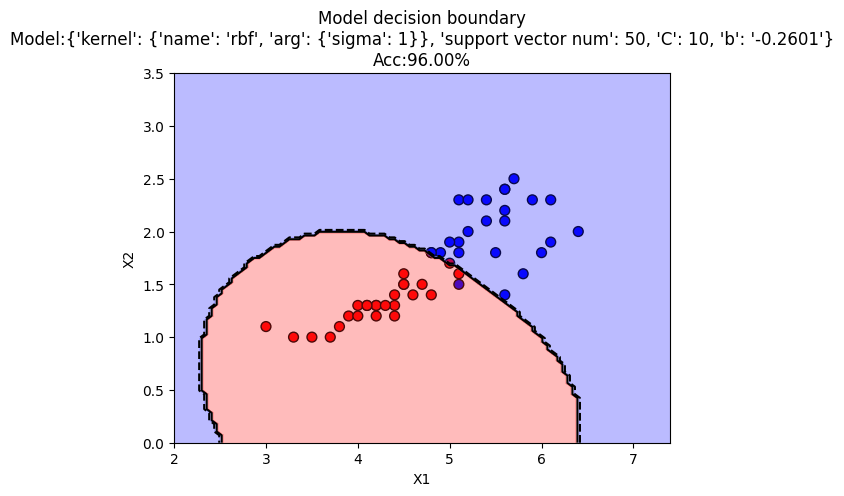

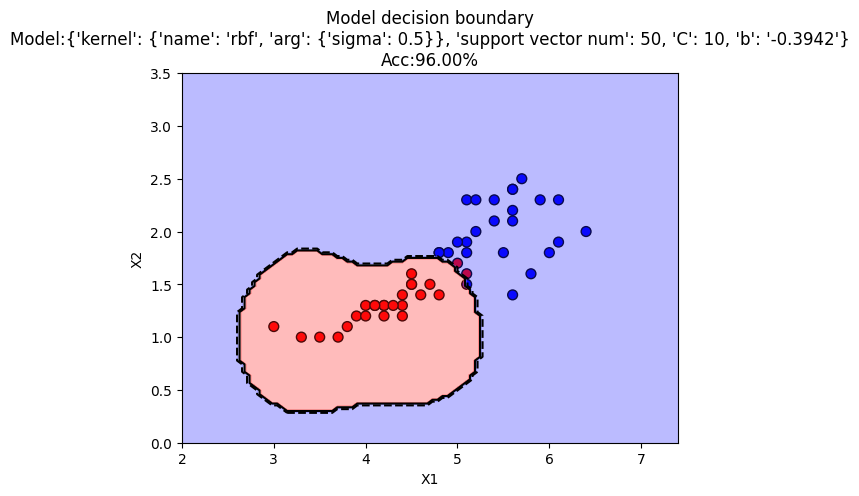

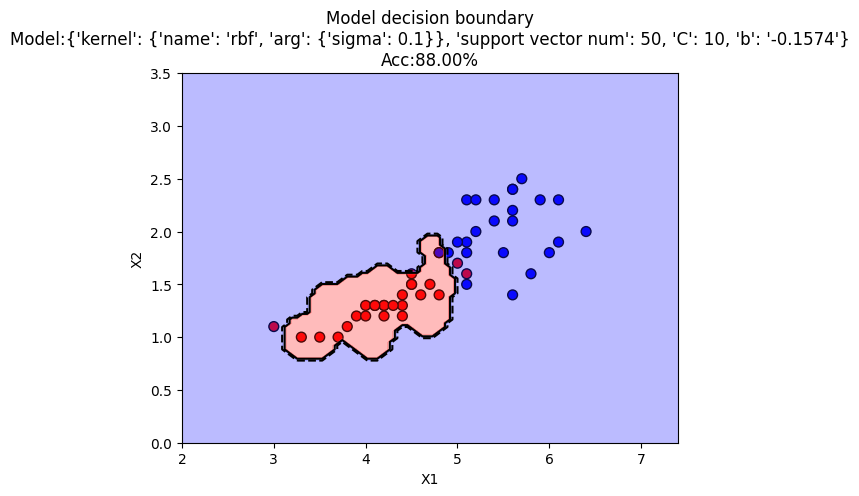

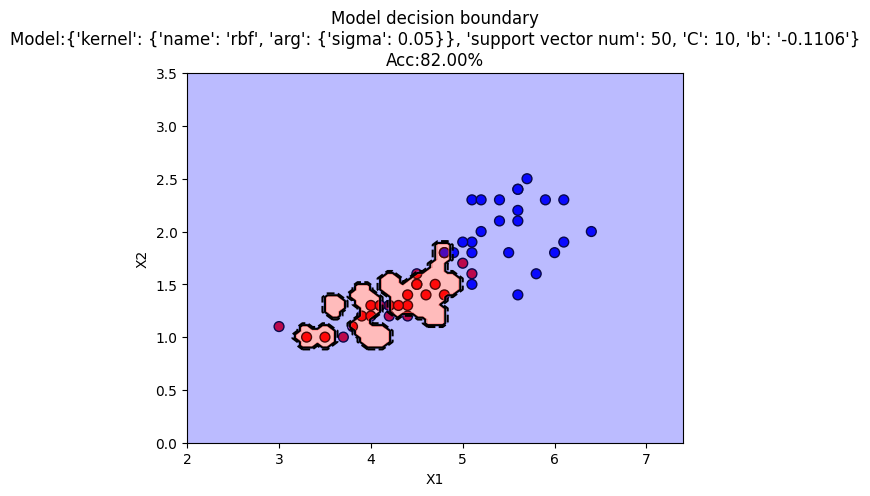

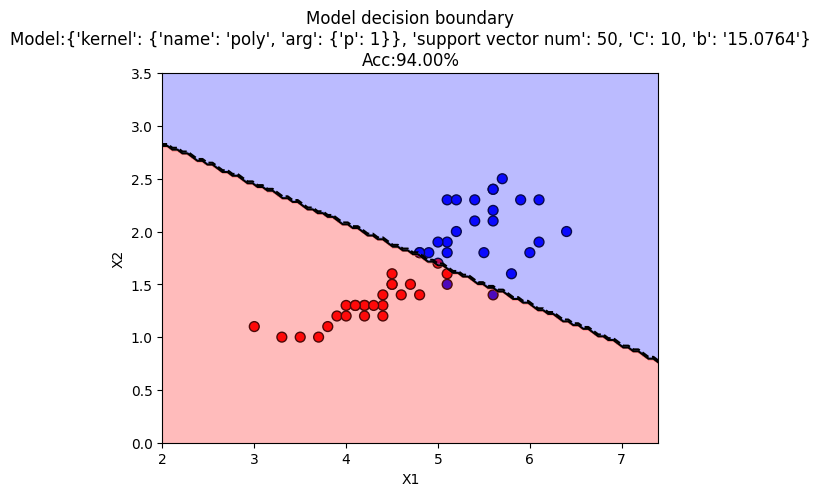

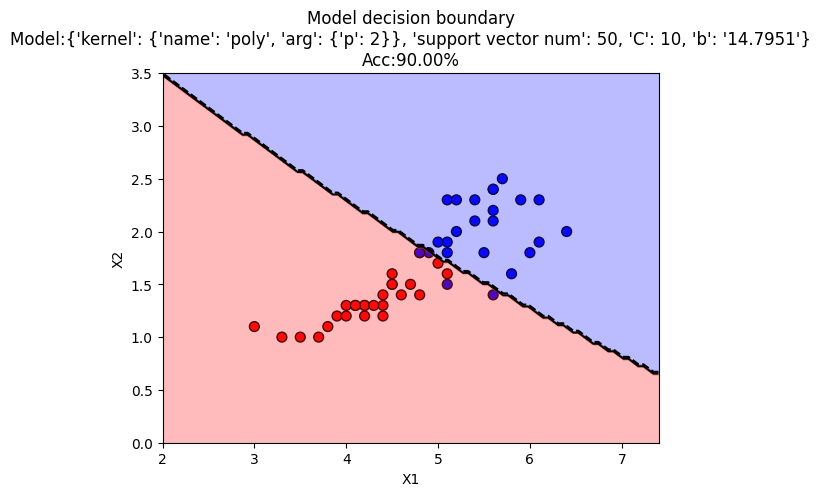

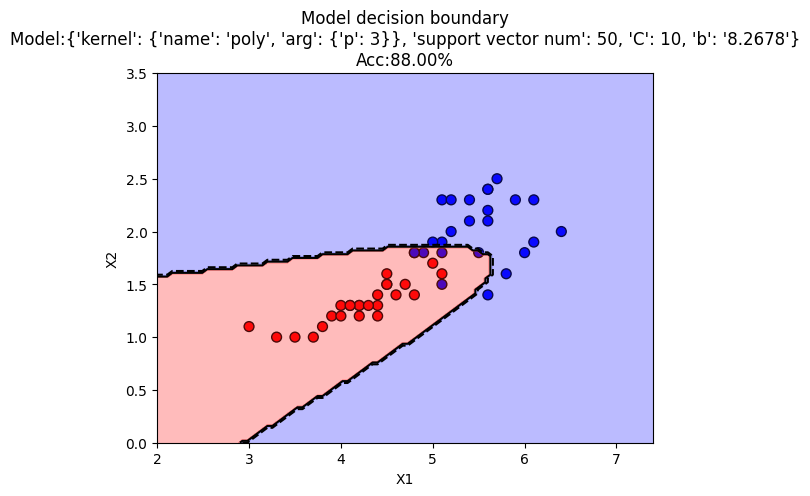

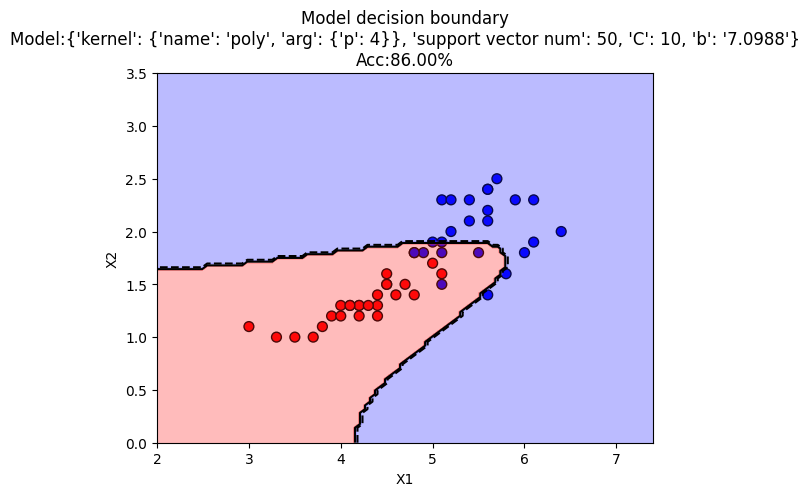

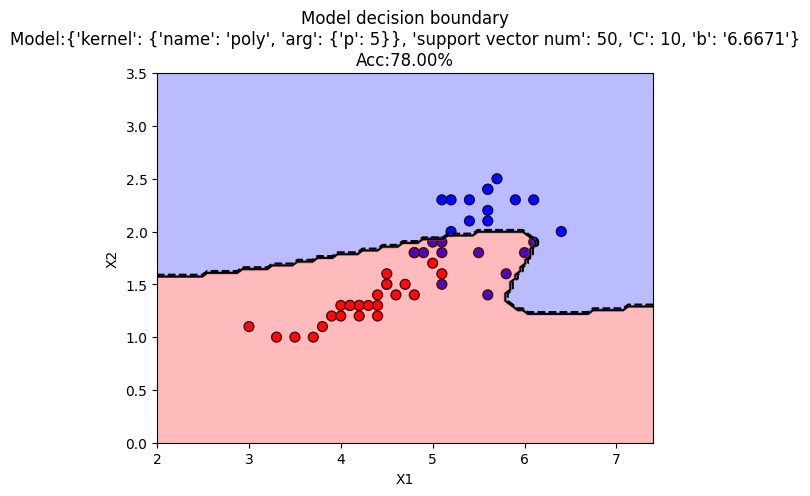

In [77]:
test_result = model_linear + model_rbf + model_poly
for test_result_item in test_result:
    test_result_item.plot_decision_boundary(assets_folder)

In [78]:
test_result = [item.to_data_dict(image_save_folder=assets_folder) for item in test_result]


In [79]:
df_test_record = pd.DataFrame(test_result)
df_test_record

,model_name,acc,alpha,bias,image
0,linear___C_1,0.96,"['1.0000', '0.0667', '1.0000', '0.0000', '1.00...",10.6297,![alt](assets/linear___C_1.png)
1,linear___C_10,0.94,"['0.0000', '0.0000', '9.0000', '0.0000', '0.00...",15.0764,![alt](assets/linear___C_10.png)
2,linear___C_100,0.92,"['0.0000', '0.0003', '44.4438', '0.0000', '0.0...",11.2977,![alt](assets/linear___C_100.png)
3,rbf_sigma_5_C_10,0.90,"['10.0000', '8.9618', '10.0000', '0.0000', '10...",0.0049,![alt](assets/rbf_sigma_5_C_10.png)
4,rbf_sigma_1_C_10,0.96,"['0.0000', '0.0000', '8.8908', '0.0000', '0.00...",-0.2601,![alt](assets/rbf_sigma_1_C_10.png)
5,rbf_sigma_0.5_C_10,0.96,"['0.0000', '0.0000', '5.9852', '0.0000', '0.00...",-0.3942,![alt](assets/rbf_sigma_0.5_C_10.png)
6,rbf_sigma_0.1_C_10,0.88,"['0.2801', '0.3292', '1.2411', '0.3631', '0.07...",-0.1574,![alt](assets/rbf_sigma_0.1_C_10.png)
7,rbf_sigma_0.05_C_10,0.82,"['0.5377', '0.3213', '0.6269', '0.5453', '0.94...",-0.1106,![alt](assets/rbf_sigma_0.05_C_10.png)
8,poly_p_1_C_10,0.94,"['0.0000', '0.0000', '9.0000', '0.0000', '0.00...",15.0764,![alt](assets/poly_p_1_C_10.png)
9,poly_p_2_C_10,0.90,"['0.0000', '0.0000', '3.8295', '0.0000', '0.00...",14.7951,![alt](assets/poly_p_2_C_10.png)


In [80]:
print(df_test_record.drop(columns=["alpha"]).to_markdown())

|    | model_name          |   acc |    bias | image                                  |
|---:|:--------------------|------:|--------:|:---------------------------------------|
|  0 | linear___C_1        |  0.96 | 10.6297 | !(assets/linear___C_1.png)        |
|  1 | linear___C_10       |  0.94 | 15.0764 | !(assets/linear___C_10.png)       |
|  2 | linear___C_100      |  0.92 | 11.2977 | !(assets/linear___C_100.png)      |
|  3 | rbf_sigma_5_C_10    |  0.9  |  0.0049 | !(assets/rbf_sigma_5_C_10.png)    |
|  4 | rbf_sigma_1_C_10    |  0.96 | -0.2601 | !(assets/rbf_sigma_1_C_10.png)    |
|  5 | rbf_sigma_0.5_C_10  |  0.96 | -0.3942 | !(assets/rbf_sigma_0.5_C_10.png)  |
|  6 | rbf_sigma_0.1_C_10  |  0.88 | -0.1574 | !(assets/rbf_sigma_0.1_C_10.png)  |
|  7 | rbf_sigma_0.05_C_10 |  0.82 | -0.1106 | !(assets/rbf_sigma_0.05_C_10.png) |
|  8 | poly_p_1_C_10       |  0.94 | 15.0764 | !(assets/poly_p_1_C_10.png)       |
|  9 | poly_p_2_C_10       |  0.9  | 14.7951 | !(assets/poly_p_2_C_10.png)       |
| 10 | poly_p_3_C_10       |  0.88 |  8.2678 | !(assets/poly_p_3_C_10.png)       |
| 11 | poly_p_4_C_10       |  0.86 |  7.0988 | !(assets/poly_p_4_C_10.png)       |
| 12 | poly_p_5_C_10       |  0.78 |  6.6671 | !(assets/poly_p_5_C_10.png)       |

In [81]:
test_result_dict = {"test_result": test_result}
test_result_dict

{'test_result': [{'model_name': 'linear___C_1',
   'acc': '0.96',
   'alpha': "['1.0000', '0.0667', '1.0000', '0.0000', '1.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0667', '0.0000', '0.0667', '0.0000', '1.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.2000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '1.0000', '0.0000', '1.0000', '0.0000']",
   'bias': '10.6297',
   'image': '![alt](assets/linear___C_1.png)'},
  {'model_name': 'linear___C_10',
   'acc': '0.94',
   'alpha': "['0.0000', '0.0000', '9.0000', '0.0000', '0.0000', '0.0000', '10.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '10.0000', '0.0000', '9.0000', '0.0000', '0.0000', '0.0000', '8.0000', '0.0000', 

In [82]:
with open(assets_folder.joinpath("test_result.json"), mode="w") as f:
    json.dump(test_result_dict,f, indent=2)